# Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
image = cv2.imread('stop.jpg')

## Mean Shift Segmentation

In [2]:
def MeanShift(image, spatial_radius, color_radius, max_iter=10, epsilon=1):
    # Get the height, width, and number of channels of the image
    height, width, channels = image.shape
    flat_image = image.reshape((-1, channels))  # Flatten the image into a 2D array where each row represents a pixel's color

    # Create a grid of spatial coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    spatial_coords = np.dstack((x, y))  # Get the coordinates of each pixel
    spatial_coords = spatial_coords.reshape((-1, 2))  # Flatten the coordinates to shape (N, 2), where N is the number of pixels

    # Compute the spatial distance weight matrix
    spatial_dist_matrix = np.linalg.norm(spatial_coords[:, np.newaxis] - spatial_coords, axis=2)
    spatial_weight_matrix = np.exp(-0.5 * (spatial_dist_matrix / spatial_radius) ** 2)

    # Perform the Mean Shift iterations
    new_flat_image = flat_image.copy()
    for _ in range(max_iter):
        for i in range(len(flat_image)):
            # Compute the color difference with the current pixel
            color_diff = flat_image - flat_image[i]  # Color difference
            color_dist = np.linalg.norm(color_diff, axis=1)
            color_weight = np.exp(-0.5 * (color_dist / color_radius) ** 2)

            # Compute the total weight (spatial weight * color weight)
            weight = color_weight * spatial_weight_matrix[i]

            # Calculate the weighted sum of colors and spatial positions
            weighted_color_sum = np.sum(weight[:, np.newaxis] * flat_image, axis=0)
            # Update the pixel value
            new_flat_image[i] = weighted_color_sum / np.sum(weight)  # Update the color value

        # If the change is below the threshold (convergence), terminate the iteration
        if np.linalg.norm(new_flat_image - flat_image) < epsilon:
            break

    # Return the final image
    return new_flat_image.reshape((height, width, channels))


(-0.5, 483.5, 639.5, -0.5)

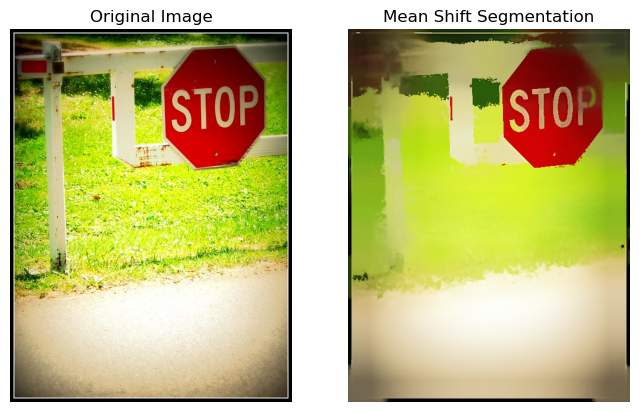

In [3]:
# use the mean shift segmentation function
segmented_image = cv2.pyrMeanShiftFiltering(image, 30, 110)
# segmented_image = MeanShift(image, 30, 110)

# display the images
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Mean Shift Segmentation')
plt.axis('off')


## Normalized Graph Cut Segmentation

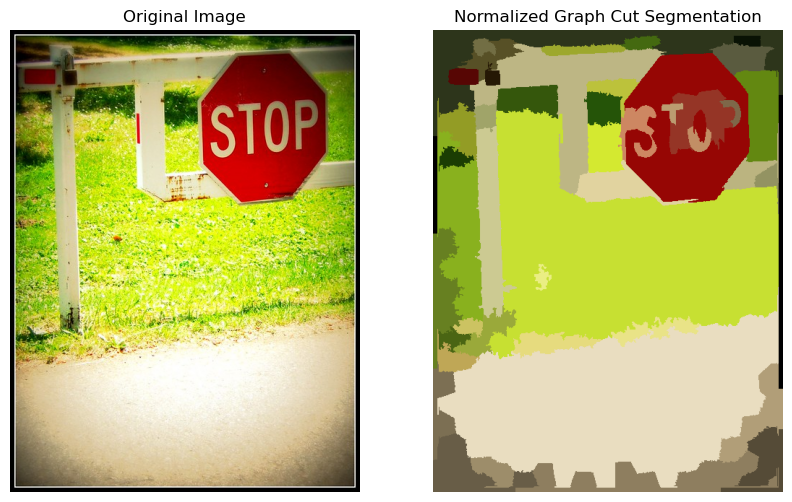

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "stop.jpg" 
image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)

# Resize the image and set the scaling factor
scale_factor = 0.2  # Scaling factor (0.2 means resizing to 20% of the original size)
image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

# Get image dimensions
h, w = image.shape
N = h * w  # Total number of pixels

# Build the graph: compute the weight matrix
sigma = 10
r = 5  # Neighborhood range
weights = np.zeros((N, N))

# Get the coordinates of all pixels
pixels = np.array([(i, j) for i in range(h) for j in range(w)])

# Compute the weight matrix for local neighborhoods
for i, (x1, y1) in enumerate(pixels):
    for j, (x2, y2) in enumerate(pixels):
        # Only consider local neighborhoods
        if abs(x1 - x2) <= r and abs(y1 - y2) <= r:
            intensity_diff = image[x1, y1] - image[x2, y2]
            spatial_dist = (x1 - x2) ** 2 + (y1 - y2) ** 2
            weight = np.exp(-intensity_diff**2 / (2 * sigma**2)) * np.exp(-spatial_dist / (2 * sigma**2))
            weights[i, j] = weight

# Normalize the graph cut
D = np.diag(np.sum(weights, axis=1))  # Degree matrix
L = D - weights  # Laplacian matrix
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
L_norm = D_inv_sqrt @ L @ D_inv_sqrt  # Normalized Laplacian matrix

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(L_norm)

# Select the two smallest eigenvectors
k = 2
indices = np.argsort(eigvals)[:k]
selected_eigvecs = eigvecs[:, indices]

# Perform simple binary segmentation using the sign of the first eigenvector
labels = np.sign(selected_eigvecs[:, 0])  # Binary segmentation using the sign of the first eigenvector

# Apply segmentation results
segmented_image = labels.reshape((h, w))

# Display the original image and the segmentation result
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Normalized Graph Cut Segmentation")
plt.imshow(segmented_image, cmap="gray")
plt.axis("off")

plt.show()
